In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import random
import copy
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from datascope.importance import SklearnModelAccuracy
from datascope.importance.shapley import ShapleyImportance, ImportanceMethod
from sklearn.pipeline import Pipeline

SEED = 1312
np.random.seed(SEED)
random.seed(SEED)

df = pd.read_csv('synthetic_letters_text_only.csv')
df

,letter,label
0,"To Whom It May Concern,\n\nI regret to write t...",negative
1,"To Whom It May Concern,\n\nI regret to inform ...",negative
2,"To Whom It May Concern,\n\nI am pleased to rec...",positive
3,"To whom it may concern,\n\nI am writing to rec...",neutral
4,"To Whom It May Concern,\n\nI regret to inform ...",negative
...,...,...
195,"To whom it may concern,\n\nI regret to inform ...",negative
196,"To Whom It May Concern,\n\nI regret to inform ...",negative
197,"Dear [Recipient's Name],\n\nI regret to inform...",negative
198,"To whom it may concern,\n\nI am pleased to rec...",positive


In [2]:
train, rest = train_test_split(df, test_size=0.5, random_state=SEED)
valid, test = train_test_split(rest, test_size=0.5, random_state=SEED)

encoder = SentenceTransformer("all-MiniLM-L6-v2")
X_train = encoder.encode(list(train.letter))
X_valid = encoder.encode(list(valid.letter))
X_test = encoder.encode(list(test.letter))

y_train = list(train.label)
y_valid = list(valid.label)
y_test = list(test.label)

In [3]:
def create_logistic_regression_model():
    return SGDClassifier(loss='log_loss', random_state=SEED)

def evaluate_logistic_regression_model(X_train, y_train, X_test, y_test):
    model = create_logistic_regression_model()
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    return { 'train_acc': train_acc, 'test_acc': test_acc, }

In [4]:
clean_impact = evaluate_logistic_regression_model(X_train, y_train, X_test, y_test)
clean_impact

{'train_acc': 0.99, 'test_acc': 0.9}

In [5]:
def inject_label_errors(original_labels, fraction, all_labels):
    labels_with_errors = copy.deepcopy(original_labels)
    count = int(len(labels_with_errors) * fraction)
    indices_for_errors = random.sample(range(len(labels_with_errors)), count)
    
    for idx in indices_for_errors:
        true_label = labels_with_errors[idx]
        other_labels = [label for label in all_labels if label != true_label]
        labels_with_errors[idx] = random.choice(other_labels)
    
    return labels_with_errors    

In [6]:
y_train_mislabeled = inject_label_errors(y_train, fraction=0.5, all_labels=['positive', 'negative', 'neutral'])
dirty_impact = evaluate_logistic_regression_model(X_train, y_train_mislabeled, X_test, y_test)
dirty_impact

{'train_acc': 0.75, 'test_acc': 0.54}

In [7]:
utility = SklearnModelAccuracy(create_logistic_regression_model())
importance = ShapleyImportance(method=ImportanceMethod.NEIGHBOR, utility=utility)

dsvs = importance.fit(X_train, y_train_mislabeled).score(X_valid, y_valid)

<Axes: ylabel='Count'>

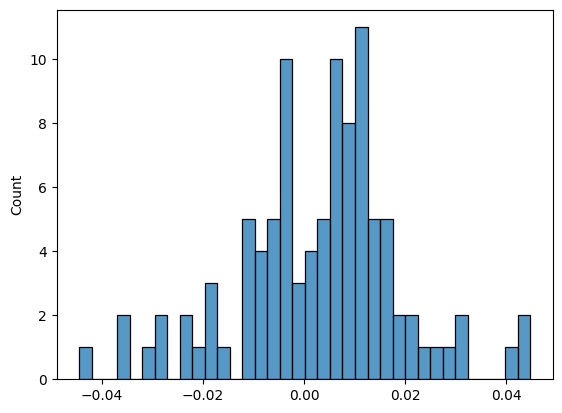

In [8]:
sns.histplot(data=dsvs, binwidth=0.0025)

In [9]:
num_negative_dsvs = np.sum(dsvs < 0)
y_train_mislabeled_some_fixes = copy.deepcopy(y_train_mislabeled)

indices = np.argsort(dsvs)[:num_negative_dsvs]

test_accs = [dirty_impact['test_acc']]

for index in indices:
    y_train_mislabeled_some_fixes[index] = y_train[index]
    impact = evaluate_logistic_regression_model(X_train, y_train_mislabeled_some_fixes, X_test, y_test)

    test_accs.append(impact['test_acc'])
        
    print(f'''
Data Shapley value: {dsvs[index]}
Given label: {y_train_mislabeled[index]}
True label: {y_train[index]}

{train.iloc[index].letter}

{'-'*80}
''')


Data Shapley value: -0.04440360620093998
Given label: positive
True label: neutral

To Whom It May Concern,

I am writing to provide a recommendation for [person], who has been a valuable asset in the ecommerce sector for several years. [Person] has consistently demonstrated a strong ability to manage online product listings, process customer orders, and handle inventory accurately. Their experience in optimizing website navigation and improving user experience has contributed positively to the team’s overall performance. Additionally, [person] has shown proficiency in customer service, addressing inquiries and resolving issues efficiently. I believe that [person] would bring a solid work ethic and practical skills to any future endeavors in the ecommerce field. 

Sincerely,  
[Your Name]

--------------------------------------------------------------------------------


Data Shapley value: -0.036542014914448376
Given label: negative
True label: neutral

To Whom It May Concern,

I am 

In [10]:
random_indices = np.random.choice(range(len(X_train)), num_negative_dsvs, replace=False)

y_train_mislabeled_random_fixes = copy.deepcopy(y_train_mislabeled)
random_test_accs = [dirty_impact['test_acc']]

for index in random_indices:
    y_train_mislabeled_random_fixes[index] = y_train[index]
    impact = evaluate_logistic_regression_model(X_train, y_train_mislabeled_random_fixes, X_test, y_test)
    random_test_accs.append(impact['test_acc'])

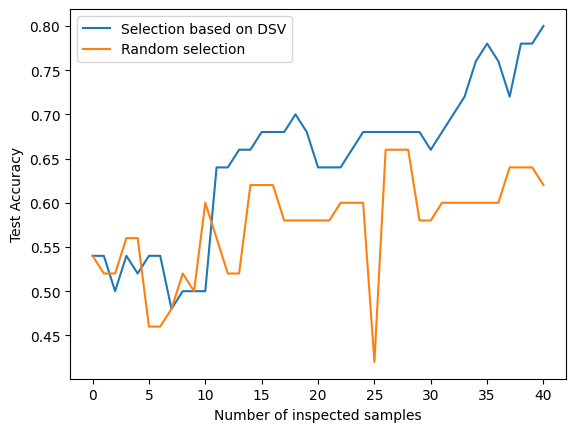

In [14]:
from scipy.ndimage import gaussian_filter1d

ax = sns.lineplot(test_accs, label="Selection based on DSV")
ax = sns.lineplot(random_test_accs, label="Random selection")


ax.set_xlabel("Number of inspected samples")
ax.set_ylabel("Test Accuracy")
ax.legend()